In [1]:
import torch as T
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import scipy.linalg
from functools import partial
%pylab
%matplotlib inline
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import scipy.sparse as sparse
from scipy import stats
from __future__ import print_function
import gc
from tqdm import tqdm
from __future__ import division
import pandas as pd
import seaborn as sb
import os
from tqdm import tqdm
from pandas import DataFrame
from scipy.spatial import distance
from scipy.cluster import hierarchy
from torchvision.transforms import Resize
import dill
from joblib import Parallel, delayed
import cv2

import os, sys, datetime
LF_CODE_PATH = os.path.expanduser('~/projects/LFAnalyze/code')
FT_CODE_PATH = os.path.expanduser('~/projects/fishTrax/code/analysis/')
FD_CODE_PATH = os.path.expanduser('~/projects/fish_despair_notebooks/src/')
sys.path.insert(0,LF_CODE_PATH)
sys.path.insert(0,FT_CODE_PATH)
sys.path.insert(0,FD_CODE_PATH)

import passivity_2p_imaging_utils as p2putils
reload(p2putils)
tmp_dir = '/tmp/'
all_data = p2putils.get_all_datasets(tmp_dir=tmp_dir)

f = all_data['e'][2]

time_fish = T.from_numpy(f.frame_st.mean(1).astype(np.float32)).cuda()
u_fish = T.cuda.FloatTensor(time_fish.shape).zero_()
p_fish = T.cuda.FloatTensor(time_fish.shape).zero_()
u_fish[numpy.searchsorted(f.frame_et[:,-1], f.shock_st,side="left")] = 1

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def get_frames_from_z(z, fish):
    tiff = fish.get_tif_rasl(z)
    ntime = fish.frame_et.shape[0]
    frames = np.zeros((ntime, tiff.frame_shape[0],tiff.frame_shape[1])).astype(np.float32)
    for t in range(ntime):
        frame = np.array(tiff.get_frame(t)).astype(np.float32)
        frames[t] = frame
    return frames

def get_imaging_from_fish(f,n_jobs=8):
    nZ = f.num_zplanes
    # frames_by_z = pool.map(partial(get_frames_from_z, fish=f), range(nZ))
    frames_by_z = Parallel(n_jobs=n_jobs)(delayed(get_frames_from_z)(z,fish=f) for z in range(nZ))
    imaging = np.stack(frames_by_z).swapaxes(0,1).astype(np.float32)
    return imaging

In [3]:
def resize_volume(images, fx, fy, interpolation=cv2.INTER_CUBIC):
    im = cv2.resize(images[0], None, fx=fx, fy=fy, interpolation=interpolation)
    new = np.zeros([images.shape[0],im.shape[0],im.shape[1]]).astype(np.float32)
    new[0] = im
    for i, img in enumerate(images[1:]):
        new[i] = cv2.resize(img, None, fx=fx, fy=fy, interpolation=interpolation)
    return new

def resize_batch(images, fx, fy, interpolation=cv2.INTER_CUBIC):
    im = cv2.resize(images[0,0], None, fx=fx, fy=fy, interpolation=interpolation)
    new = np.zeros([images.shape[0],images.shape[1], im.shape[0],im.shape[1]]).astype(np.float32)
    for b, vol in enumerate(images):
        for z, img in enumerate(vol):
            new[b,z] = cv2.resize(img, None, fx=fx, fy=fy, interpolation=interpolation)
    return new

In [4]:
imaging = get_imaging_from_fish(f)

In [5]:
class FishImageData(Dataset):    
    def __init__(self, imaging):
        self.data = T.from_numpy(imaging)
        
    def __len__(self):
        return self.data.shape[0]-1

    def __getitem__(self, idx):
        return self.data[idx], self.data[idx+1]

data = FishImageData(imaging)
batch_size = 64
nZ, H, W = data[0][0].shape

In [20]:
data[0][0].shape

torch.Size([11, 232, 512])

In [61]:
def get_padding(padding_type, kernel_size):
    assert padding_type in ['SAME', 'VALID']
    if padding_type == 'SAME':
        return tuple((k - 1) // 2 for k in kernel_size)
    return tuple(0 for _ in kernel_size)

class Conv(nn.Module):
    def __init__(self, nZ=11, H=232, W=512, nEmbedding=20):
        super(Conv, self).__init__()
        self.nZ = nZ
        self.H = H
        self.W = W
        self.lowH = 11
        self.lowW = 25
        self.lowFeatures = 16
        # batch x channel x Z x H x W
        # Encoding
        self.conv1 = nn.Parameter(T.cuda.FloatTensor(8,1,9,9))
#         self.conv1 = nn.Conv2d(1,1,1,9,9)
        self.pad1 = get_padding('SAME',(9,9))
        self.activation = nn.ReLU()
        self.conv2 = nn.Parameter(T.cuda.FloatTensor(self.lowFeatures,8,9,9))
        self.pad2 = get_padding('SAME',(9,9))
        # b x 11 x 32 x 11 x 25
        self.encoding = nn.Linear(self.lowFeatures*self.nZ*self.lowH*self.lowW, nEmbedding)
        
        # Decoding (super resolution)
        # https://arxiv.org/pdf/1609.05158.pdf
        upscale_factor = 22
        self.decoding = nn.Linear(nEmbedding,self.lowFeatures*nZ*self.lowH*self.lowW)
        self.dconv1 = nn.Parameter(T.cuda.FloatTensor(64,16,5,5))
        self.dpad1 = (2,2)
        self.dconv2 = nn.Parameter(T.cuda.FloatTensor(64,64,3,3))
        self.dpad2 = (1,1)
        self.dconv3 = nn.Parameter(T.cuda.FloatTensor(32,64,3,3))
        self.dpad3 = (1,1)
        self.dconv4 = nn.Parameter(T.cuda.FloatTensor(upscale_factor**2,32,3,3))
        self.dpad4 = (1,1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        
        self._initialize_weights()
                
    def vol_conv(self, x, weight, pad):
        # batch x Z x C x H x W
        activations = T.cuda.FloatTensor(x.shape[0],x.shape[1],weight.shape[0],x.shape[3],x.shape[4])
        for z in range(x.shape[1]):
            activations[:,z] = F.conv2d(x[:,z], weight, padding=pad)
        return activations
    
    def vol_MaxPool2d(self, x, kernel_size):
        # batch x Z*C x H x W
        input = x.view(x.shape[0],-1,x.shape[3],x.shape[4])
        pooled = F.max_pool2d(input,kernel_size)
        return pooled.reshape(pooled.shape[0],x.shape[1],x.shape[2],pooled.shape[2],pooled.shape[3])
    
    def vol_PixelShuffle(self, x):
        first = self.pixel_shuffle(x[:,0])
        # b x z x H x W
        ret = T.cuda.FloatTensor(x.shape[0],x.shape[1],first.shape[2], first.shape[3])
        for z in range(x.shape[1]):
            ret[:,z] = self.pixel_shuffle(x[:,z])[:,0]
        return ret
        
        # batch x Z*C x H x W
        input = x.view(x.shape[0],-1,x.shape[3],x.shape[4])
        pooled = F.max_pool2d(input,kernel_size)
        return pooled.reshape(pooled.shape[0],x.shape[1],x.shape[2],pooled.shape[2],pooled.shape[3])
    
    def encode(self, x):
        # b x 11 x 1 x 232 x 512
        x = self.activation(self.vol_MaxPool2d(self.vol_conv(x, self.conv1, self.pad1),4))
        # b x 11 x 8 x 58 x 128
        x = self.activation(self.vol_MaxPool2d(self.vol_conv(x, self.conv2, self.pad2),5))
        # b x 11 x 32 x 11 x 25
        x = self.activation(self.encoding(x.reshape(x.shape[0],-1)))
        return x
    
    def crop(self, x):
        cropH = (x.shape[2] - self.H)/2
        cropW = (x.shape[3] - self.W)/2
        x = x[:,:,int(np.floor(cropH)):-int(np.ceil(cropH))]
        x = x[:,:,:,int(np.floor(cropW)):-int(np.ceil(cropW))]
        return x

    def decode(self, x):
        # b x 20
        x = self.activation(self.decoding(x))
        x = x.reshape(x.shape[0],self.nZ,self.lowFeatures,self.lowH,self.lowW)
        # b x 11 x 32 x 11 x 25
        x = self.activation(self.vol_conv(x, self.dconv1, self.dpad1))
        x = self.activation(self.vol_conv(x, self.dconv2, self.dpad2))
        x = self.activation(self.vol_conv(x, self.dconv3, self.dpad3))
        x = self.vol_PixelShuffle(self.vol_conv(x, self.dconv4, self.dpad4))
        return self.crop(x)

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded
    
    def _initialize_weights(self):
        nn.init.orthogonal_(self.conv1, nn.init.calculate_gain('relu'))
        nn.init.orthogonal_(self.conv2, nn.init.calculate_gain('relu'))
        nn.init.orthogonal_(self.dconv1, nn.init.calculate_gain('relu'))
        nn.init.orthogonal_(self.dconv2, nn.init.calculate_gain('relu'))
        nn.init.orthogonal_(self.dconv3, nn.init.calculate_gain('relu'))
        nn.init.orthogonal_(self.dconv4, nn.init.calculate_gain('relu'))


# def train(model,data,nepochs=10, lambdaA=(1e-8, 1e-6), lambdaB=(1e-6, 1e-6),
#           lambdaC=(1e-5, 1e-5), lambdaD=(1e-5, 1e-5), lr=0.1, verbose=True):
def train(model,data,nepochs=10, lr=0.1):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    optimizer = T.optim.Adam(model.parameters(),lr=lr)
    
    for e in range(nepochs):
        print("epoch {}: ".format(e), end="")
        cum_loss = 0
        for batch_data in dataloader:
            X, Y = batch_data
            # add 1 channel
            Y_pred = model(X[:,:,None].cuda())
            loss = F.mse_loss(Y_pred,Y.cuda())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            cum_loss += float(loss)

        print("avg_loss: {:3E}".format(cum_loss/len(data)))

nEmbedding = 20
batch_size = 60
nZ, H, W = data[0][0].shape

conv_model = Conv(nZ,H,W,nEmbedding)
conv_model.cuda()
# conv_model(data[0][0][None,:,None].cuda()).shape
train(conv_model,data,25,lr=1e-3)
# 1.91E+02

epoch 0: avg_loss: 1.641004E+02
epoch 1: avg_loss: 9.895861E+01
epoch 2: avg_loss: 9.230034E+01
epoch 3: avg_loss: 8.840658E+01
epoch 4: avg_loss: 8.568716E+01
epoch 5: avg_loss: 8.372715E+01
epoch 6: avg_loss: 8.188881E+01
epoch 7: avg_loss: 8.108087E+01
epoch 8: avg_loss: 7.988315E+01
epoch 9: avg_loss: 7.928647E+01
epoch 10: avg_loss: 7.818839E+01
epoch 11: avg_loss: 7.714311E+01
epoch 12: avg_loss: 7.613720E+01
epoch 13: avg_loss: 7.564090E+01
epoch 14: avg_loss: 7.478984E+01
epoch 15: avg_loss: 7.416900E+01
epoch 16: avg_loss: 7.383862E+01
epoch 17: avg_loss: 7.327902E+01
epoch 18: avg_loss: 7.337743E+01
epoch 19: avg_loss: 7.258598E+01
epoch 20: avg_loss: 7.177017E+01
epoch 21: avg_loss: 7.148916E+01
epoch 22: avg_loss: 7.116184E+01
epoch 23: avg_loss: 7.084152E+01
epoch 24: avg_loss: 7.064146E+01


In [89]:
def plot_model_vs_real(model,data):
    plt.figure(figsize=(15,15))

    with T.no_grad():
        for i in range(4):
            time = np.random.randint(len(data))
            z = np.random.randint(nZ)
            X, Y = data[time]
            x = X.cuda()
            y = Y.cuda()
            X_pred = model(x[None,:,None])
            loss = float(F.mse_loss(X_pred[0],y).cpu())
            prev_loss = float(F.mse_loss(x,y).cpu())
            zero_loss = float(F.mse_loss(y,T.zeros_like(y)).cpu())
            mymax = max(float(Y[0,z].max()[0]),float(X[0,z].max()[0]),float(X_pred[0,z].max()[0]))
            plt.subplot(4,3,i*3+1)
            plt.imshow(X[z].cpu().numpy(), vmin=0, vmax=mymax)
            plt.title("Time="+str(time) + ", z="+str(z))
            plt.subplot(4,3,i*3+2)
            plt.imshow(Y[z].cpu().numpy(), vmin=0, vmax=mymax)
            plt.title("Time="+str(time+1) + ", z="+str(z))
            plt.subplot(4,3,i*3+3)
            plt.imshow(X_pred[0,z].cpu().numpy(), vmin=0, vmax=mymax)
            plt.title("MSE: Pred={:.0f}, Prev={:.0f}, Zero={:.0f}".format(loss,prev_loss,zero_loss))


/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/ubuntu/anaconda3/envs/pytorch_

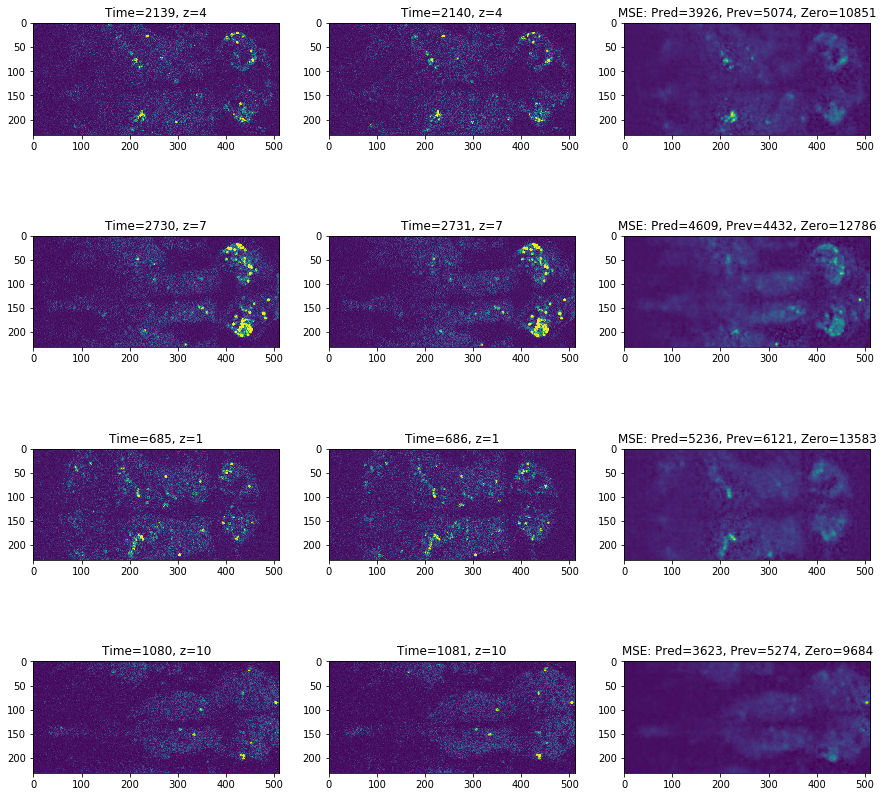

In [91]:
# 6.00E+1
plot_model_vs_real(conv_model,data)

In [92]:
np.eye(20)[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [115]:
prev_img = T.zeros(10,10, requires_grad=True)
prev_img + 1
prev_img.requires_grad

True

In [185]:
embedding[None].shape

torch.Size([1, 20])

In [212]:
def get_gradient_from_embedding(model,frame,embedding,niters=20, lr=1e-3):
    model.eval()
    frame = frame[None,:,None].cuda()
    frame.requires_grad = True
    embedding_pred = model.encode(frame)
    embedding_pred.backward(gradient=embedding)
    return frame.grad[0,:,0]

frame = data[0][0]
embedding = T.from_numpy(np.eye(20)[10].astype(np.float32)).cuda()
prev_img = get_gradient_from_embedding(conv_model, frame, embedding)
with T.no_grad():
    next_img = conv_model.decode(embedding[None])[0]

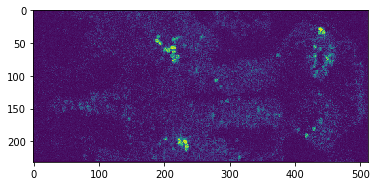

In [308]:
def get_input_from_embedding(model,frame,embedding,niters=75, lr=1e-1):
    "Take an embedding vector, and use backprop to find the volume"
    if type(frame)==str and frame=='rand':
        prev_img = T.rand_like(frame[None,:,None], requires_grad=True)
    else:
        prev_img = frame[None,:,None].cuda()
        prev_img.requires_grad = True
    optimizer = T.optim.Adam([prev_img],lr=lr)
    model.eval()
    for i in range(niters):
        embedding_pred = model.encode(prev_img)
        loss = F.mse_loss(embedding_pred,embedding[None]) #+ 1e-7*T.norm(prev_img,1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         print("iter {} loss: ".format(i), float(loss))
    model.train()
    return prev_img[0,:,0].detach().cpu().numpy()

frame = data[0][0]
# frame = 'rand'
embedding = T.from_numpy(1000*np.eye(20)[10].astype(np.float32)).cuda()
prev_img = get_input_from_embedding(conv_model, frame, embedding,niters=81)
plt.imshow(prev_img[6])

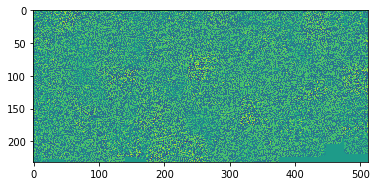

In [309]:
plt.imshow(prev_img[6] - frame[6])

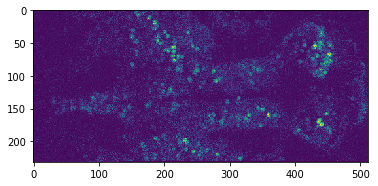

In [310]:
frame = data[500][0]
# frame = 'rand'
embedding = T.from_numpy(1000*np.eye(20)[10].astype(np.float32)).cuda()
prev_img = get_input_from_embedding(conv_model, frame, embedding,niters=100)
plt.imshow(prev_img[6])

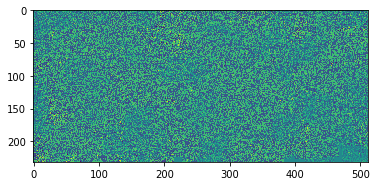

In [311]:
plt.imshow(prev_img[6] - frame[6])

In [291]:
conv_model.encode(T.from_numpy(prev_img[None,:,None]).cuda())

tensor([[   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
            0.0000,    0.0000,    0.0000,    0.0000,  998.1810,    0.0000,
            0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
            0.0000,    0.0000]], device='cuda:0')

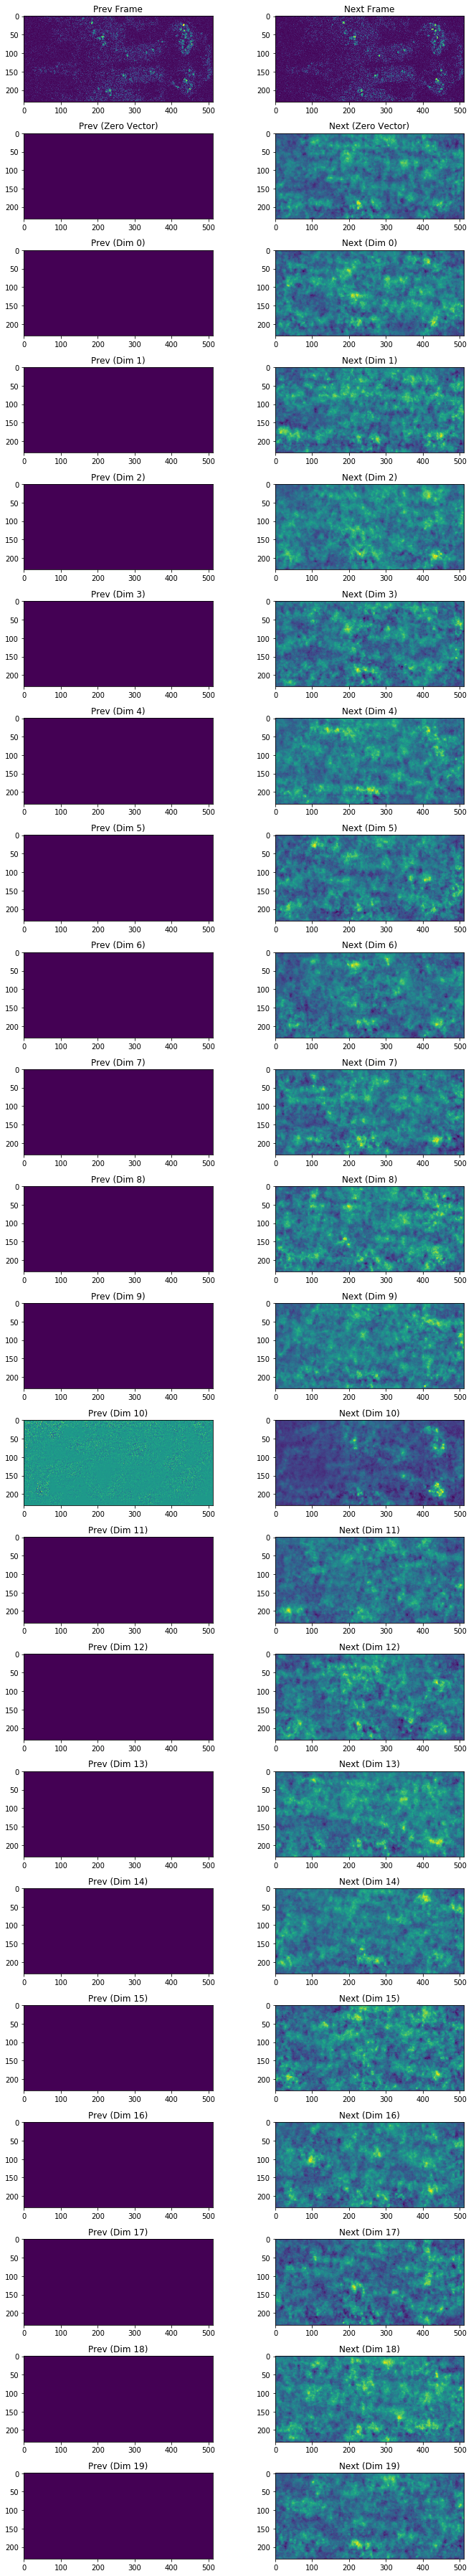

In [237]:
def interpret(model,prev_vol, next_vol, nEmbedding, prev_func):
    "Plot prev & next frame for each latent dimension"
    plt.figure(figsize=(10,50))
    plt.subplot(2+nEmbedding,2,1)
    plt.imshow(prev_vol[6])
    plt.title("Prev Frame")
    plt.subplot(2+nEmbedding,2,2)
    plt.imshow(next_vol[6])
    plt.title("Next Frame")
    
    embedding = T.from_numpy(np.zeros(20).astype(np.float32)).cuda()[None]
    with T.no_grad():
        next_img = model.decode(embedding)[0]
    prev_img = prev_func(model, prev_vol, embedding)
    plt.subplot(2+nEmbedding,2,3)
    plt.imshow(prev_img[6])
    plt.title("Prev (Zero Vector)")
    plt.subplot(2+nEmbedding,2,4)
    plt.imshow(next_img[6])
    plt.title("Next (Zero Vector)")
    for i in range(nEmbedding):
        embedding = T.from_numpy(np.eye(nEmbedding)[i].astype(np.float32)).cuda()[None]
        with T.no_grad():
            next_img = model.decode(embedding)[0]
        prev_img = prev_func(model, prev_vol, embedding)
        plt.subplot(2+nEmbedding,2,i*2+5)
        plt.imshow(prev_img[6])
        plt.title("Prev (Dim {})".format(i))
        plt.subplot(2+nEmbedding,2,i*2+6)
        plt.imshow(next_img[6])
        plt.title("Next (Dim {})".format(i))
    plt.tight_layout()

x, y = data[1000]
interpret(conv_model,x,y,20,get_gradient_from_embedding)

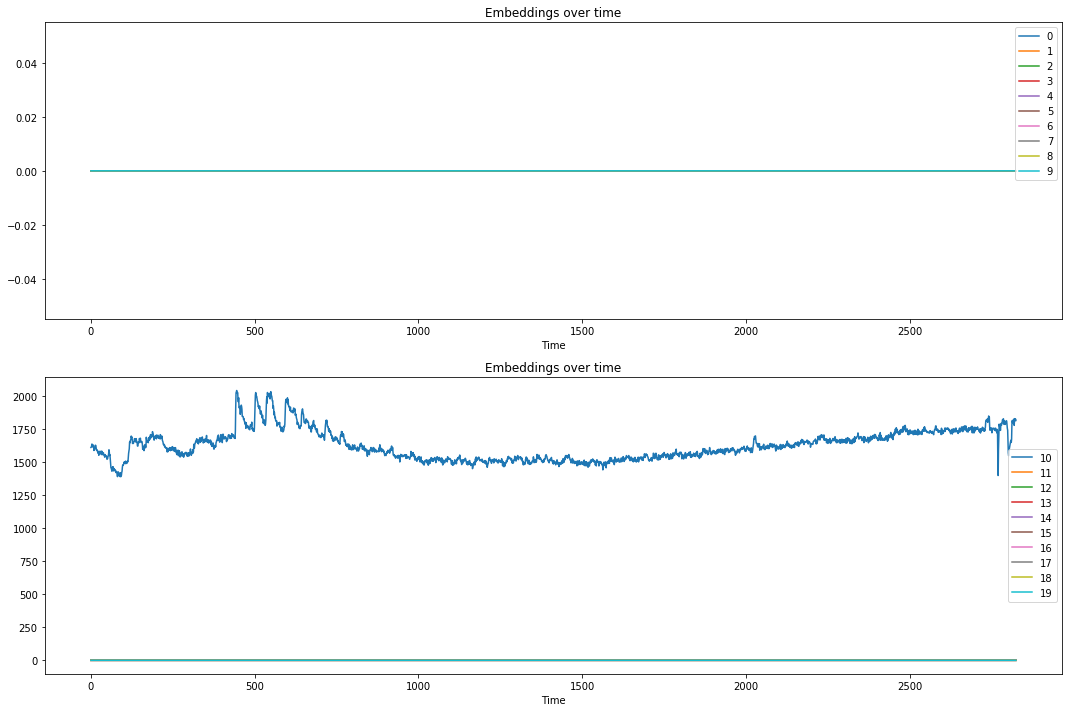

In [238]:
def plot_embedding_over_time(model,data, batch_size=64):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False)
    embeddings = []
    for batch_data in dataloader:
        X, _ = batch_data
        # add 1 channel
        with T.no_grad():
            embedding = model.encode(X[:,:,None].cuda())
        embeddings.append(embedding.cpu().numpy())
    embeddings = np.vstack(embeddings)
    nEmbeddings = embeddings.shape[1]
    half = int(np.ceil(nEmbeddings / 2))
    plt.figure(figsize=(15,10))
    plt.subplot(2,1,1)
    plt.plot(embeddings[:,0:half])
    plt.title("Embeddings over time")
    plt.xlabel("Time")
    plt.legend(np.arange(half))
    plt.subplot(2,1,2)
    plt.plot(embeddings[:,half:])
    plt.title("Embeddings over time")
    plt.xlabel("Time")
    plt.legend(np.arange(half,nEmbeddings))
    plt.tight_layout()
    return embeddings
embeddings = plot_embedding_over_time(conv_model,data)

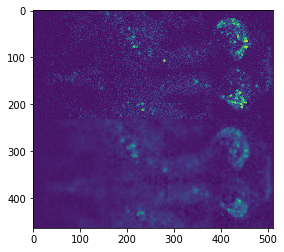

In [321]:
import skvideo.io
def makePredVideo(model, data, batch_size=64):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False)
    writer = skvideo.io.FFmpegWriter("180703_conv_model_pred.mp4",outputdict={
        '-b': '30000000'})
    for batch_data in dataloader:
        X, _ = batch_data
        with T.no_grad():
            vol_preds = model(X[:,:,None].cuda())
        for actual,pred in zip(X,vol_preds):
            # 7th z layer
            f = pred[6]
            H = f.shape[0]
            frame = np.zeros([H*2,f.shape[1]])
            frame[:H] = actual[6]
            frame[H:] = pred[6]
            writer.writeFrame(frame)
            
    writer.close()
makePredVideo(conv_model,data)

In [24]:
device = T.device('cuda')
class VAE(nn.Module):
    def __init__(self, nZ, H, W, nHidden=100, nEmbedding=20):
        super(VAE, self).__init__()
        self.nZ = nZ
        self.H = H
        self.W = W
        self.nEmbedding = nEmbedding
        self.fc1 = nn.Linear(nZ*H*W, 100)
        self.fc21 = nn.Linear(100, nEmbedding)
        self.fc22 = nn.Linear(100, nEmbedding)
        self.fc3 = nn.Linear(nEmbedding, 100)
        self.fc4 = nn.Linear(100, nZ*H*W)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))
    
    def forward(self, x):
        mu, logvar = self.encode(x.reshape(x.shape[0],-1))
        z = self.reparameterize(mu, logvar)
        return self.decode(z).reshape(x.shape), mu, logvar

    
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    KLD = 0.5 * torch.mean(mu**2 + stddev_sq - torch.log(stddev_sq) - 1)
    return MSE + KLD

def train(model,data,nepochs=10, lr=0.1):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    optimizer = T.optim.Adam(model.parameters(),lr=lr)
    
    for e in range(nepochs):
        print("epoch {}: ".format(e), end="")
        cum_loss = 0
        for batch_data in dataloader:
            X, Y = batch_data
            x = X.cuda()
            recon_batch, mu, logvar = model(x)
            loss = loss_function(recon_batch, x, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            cum_loss += loss.item()
            optimizer.step()
            cum_loss += float(loss)

        print("avg_loss: {:3E}".format(cum_loss/len(data)))
        with torch.no_grad():
            sample = torch.randn(64, model.nEmbedding).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 11, model.H, model.W)[:,[0]],
                       'results/sample_' + str(e) + '.png')

model = VAE(nZ,H,W,64,16)
model.cuda()

train(model,data, lr=1e-3)

epoch 0: avg_loss: NAN
epoch 1: avg_loss: NAN
epoch 2: avg_loss: NAN
epoch 3: avg_loss: NAN
epoch 4: avg_loss: NAN
epoch 5: avg_loss: NAN
epoch 6: 

KeyboardInterrupt: 

In [88]:
conv_model.encode(X[None,:,None].cuda()).shape

torch.Size([1, 20])

In [82]:
print("total num params:", np.sum([np.prod(x.shape) for x in conv_model.parameters()]))

total num params: 2215724
